In [2]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 22, 'grid.linestyle': '-', 'grid.color': 'gray' })


In [3]:
dataset_raw_file = "../data/output/dataset_raw.tsv"
datase_file = "../data/output/dataset.tsv"
references_dir = "../data/output/references"
ncbi_tax_file = "../data/new_taxdump/rankedlineage.dmp"

# Output
fig_dir = "../data/output/references_stat"

In [4]:
tuples = []
for reference_file in os.listdir(references_dir):
    with open("{}/{}".format(references_dir, reference_file)) as f:
        data = {}
        reference_name = reference_file.split(".")[0]
        group = None
        for k in ['linker', 'binding', 'disorder']:  # order matters
            if k in reference_name:
                group = k
                break
        for line in f:
            if line:
                if line[0] == ">":
                    name = line.strip()[1:]
                    data.setdefault(name, [])
                else:
                    data[name].append(list(line.strip()))
        for name in data:
            for i, (aa, val) in enumerate(zip(*data[name])):
                tuples.append((group, reference_name, name, i + 1, aa, val))
df_references = pd.DataFrame(tuples, columns=['group', 'reference', 'disprot_id', 'pos', 'aa', 'value'])
df_references.set_index(['group', 'reference', 'disprot_id', 'pos', 'aa'], inplace=True)
df_references

value
group    reference         disprot_id pos  aa      
linker   linker            DP02418    1    M      0
                                      2    A      0
                                      3    S      0
                                      4    P      0
                                      5    P      0
...                                             ...
disorder disorder_pdb_fill DP03746    1280 Q      1
                                      1281 L      1
                                      1282 L      1
                                      1283 I      1
                                      1284 R      1

[1238989 rows x 1 columns]

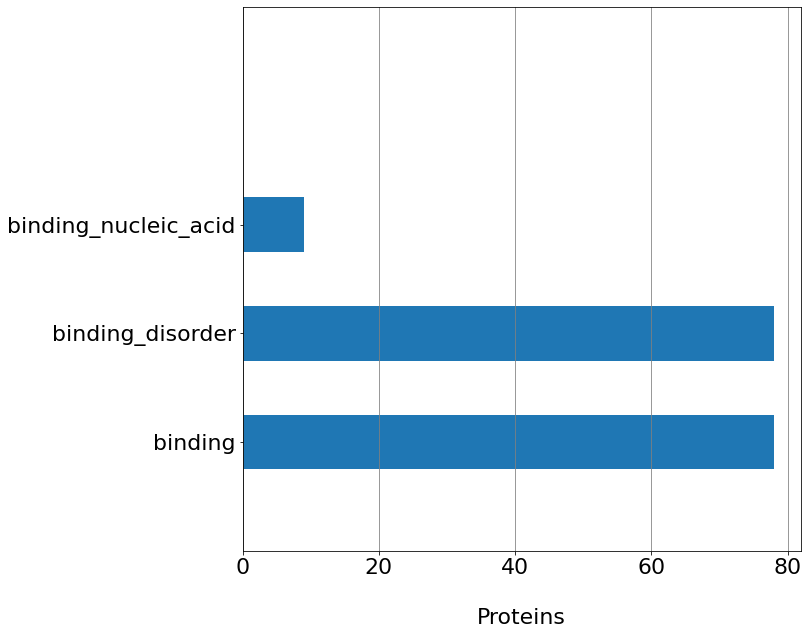

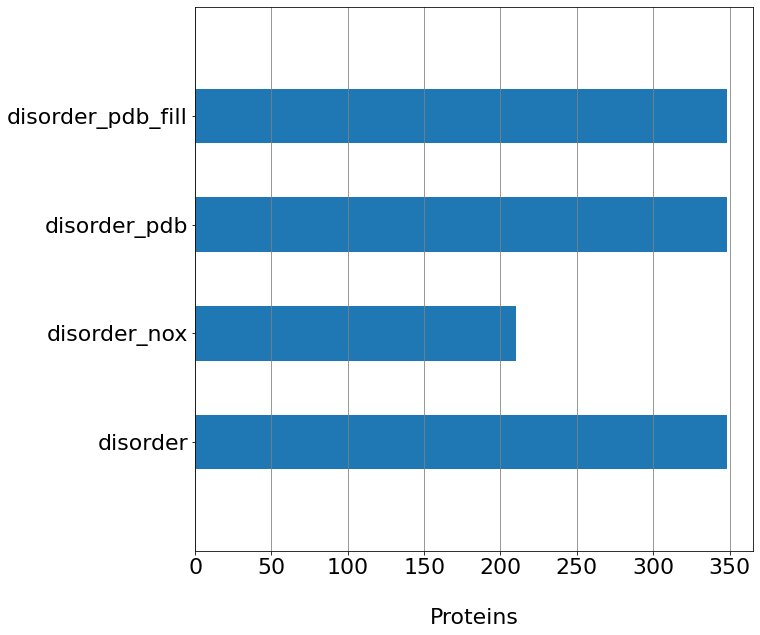

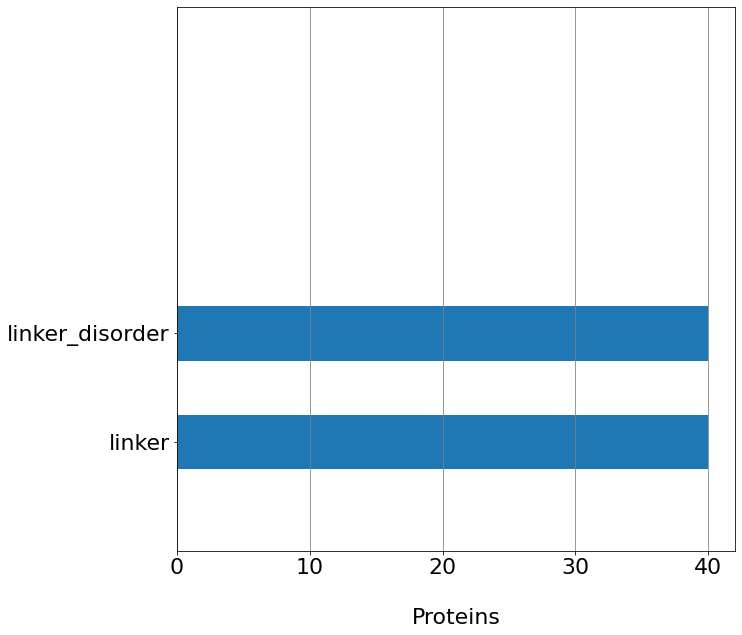

In [5]:
for group, df_g in df_references.groupby(level='group'):
    df2 = df_g.reset_index(level='disprot_id').groupby(['reference'])['disprot_id'].nunique().reset_index().set_index('reference')
    # print(df2)

    fig, ax = plt.subplots(figsize=(10, 10))
    df2.plot(kind='barh', width=0.5, ax=ax)
    ax.xaxis.grid()
    ax.set_ybound(-1, 4)
    ax.get_legend().remove()
    ax.set_xlabel('Proteins', labelpad=30)

    fig.gca().set_ylabel("")
    # fig.savefig("{}/stat_proteins_{}.png".format(fig_dir, group), dpi=300, bbox_inches='tight')

In [6]:
idx = pd.IndexSlice
df_references.loc[idx[:, ['disorder', 'linker', 'binding', 'binding_nucleic_acid'], :, :, :], :]
# df_references.index.get_level_values('reference').unique()

value
group    reference            disprot_id pos  aa      
disorder disorder             DP02342    1    M      1
                                         2    L      1
                                         3    C      1
                                         4    C      1
                                         5    M      1
...                                                ...
binding  binding_nucleic_acid DP03669    1308 S      0
                                         1309 V      0
                                         1310 E      0
                                         1311 C      0
                                         1312 R      0

[399828 rows x 1 columns]

Index(['binding_nucleic_acid', 'binding', 'linker', 'disorder'], dtype='object', name='reference')


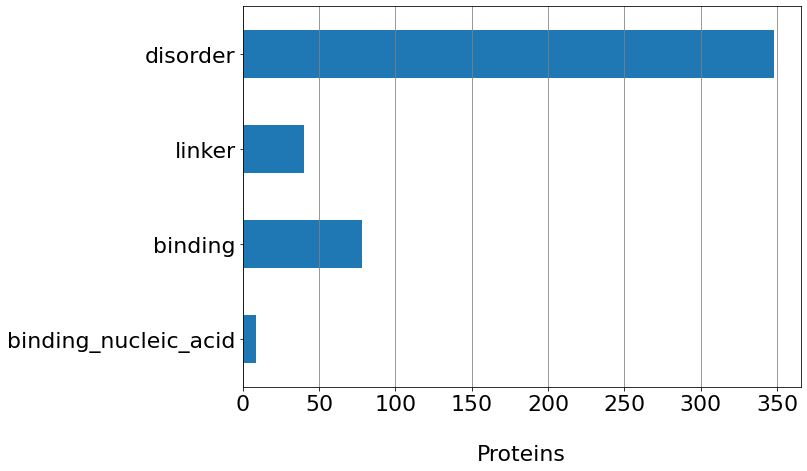

In [7]:
# Proteins
df2 = df_references.loc[idx[:, ['disorder', 'linker', 'binding', 'binding_nucleic_acid'], :, :, :], :]

sorterIndex = dict(zip(['binding_nucleic_acid', 'binding', 'linker', 'disorder'], range(4)))
df2 = df2.reset_index(level='disprot_id').groupby(['reference'])['disprot_id'].nunique().reset_index().set_index('reference').sort_values(by='reference', key=lambda x: x.map(sorterIndex))
print(df2.index.get_level_values('reference').unique())

fig, ax = plt.subplots(figsize=(10, 7))
df2.plot(kind='barh', width=0.5, ax=ax)
ax.xaxis.grid()
# ax.set_ybound(-1, 4)
ax.get_legend().remove()
ax.set_xlabel('Proteins', labelpad=30)

fig.gca().set_ylabel("")
fig.savefig("{}/stat_proteins.png".format(fig_dir), dpi=300, bbox_inches='tight')

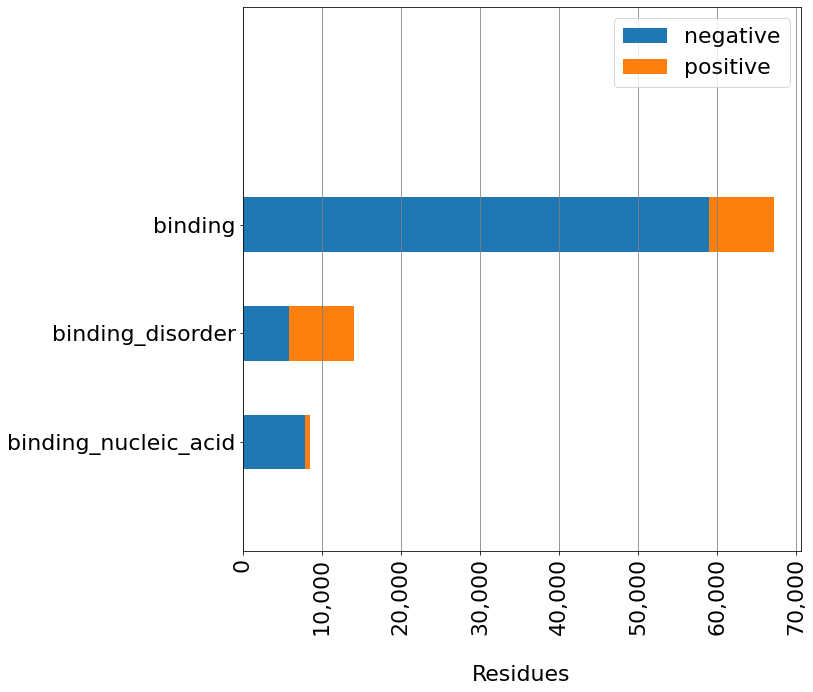

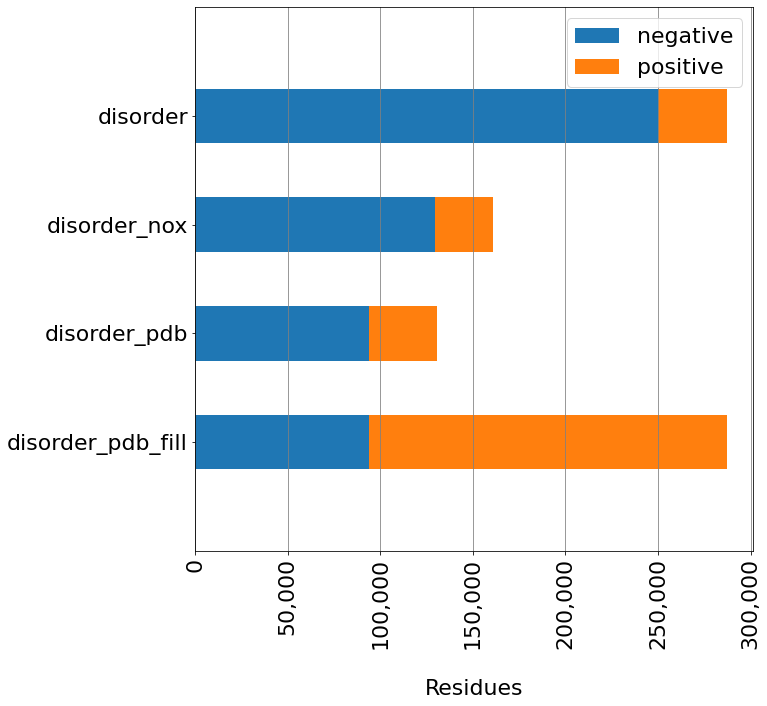

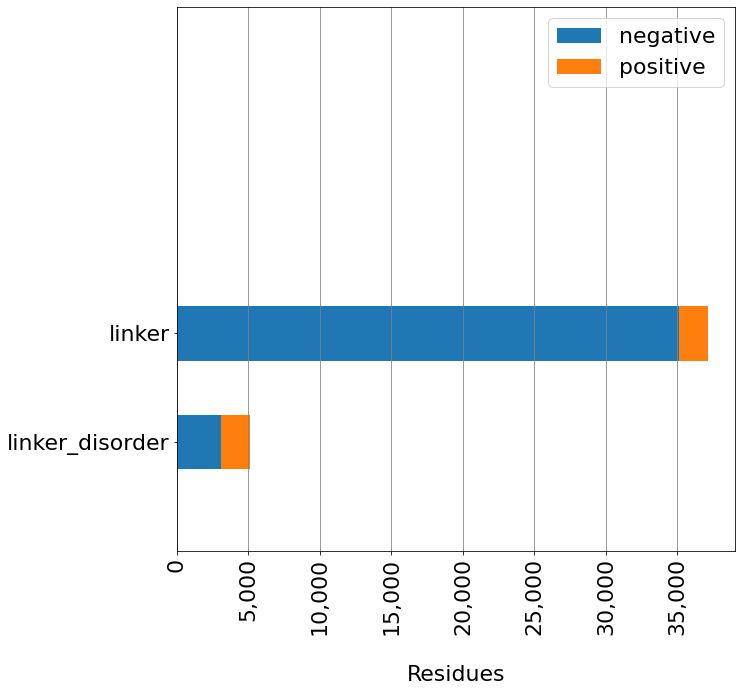

In [8]:
# TODO print the ratio (%) on top of the bars
for group, df_g in df_references.groupby(level='group'):
    df2 = df_g.groupby(['reference'])['value'].value_counts().unstack('value').fillna(0).sort_values(by=['reference'], ascending=[False]).drop(columns=['-'])
    # print(df2)

    fig, ax = plt.subplots(figsize=(10, 10))
    df2.plot(kind='barh', stacked=True, ax=ax)
    ax.xaxis.grid()
    ax.set_ybound(-1, 4)
    ax.set_xlabel('Residues', labelpad=30)
    ax.xaxis.set_major_formatter( matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.tick_params(axis='x', labelrotation=90)

    ax.legend(['negative', 'positive'])

    fig.gca().set_ylabel("")
    fig.savefig("{}/stat_residues_{}.png".format(fig_dir, group), dpi=300, bbox_inches='tight')

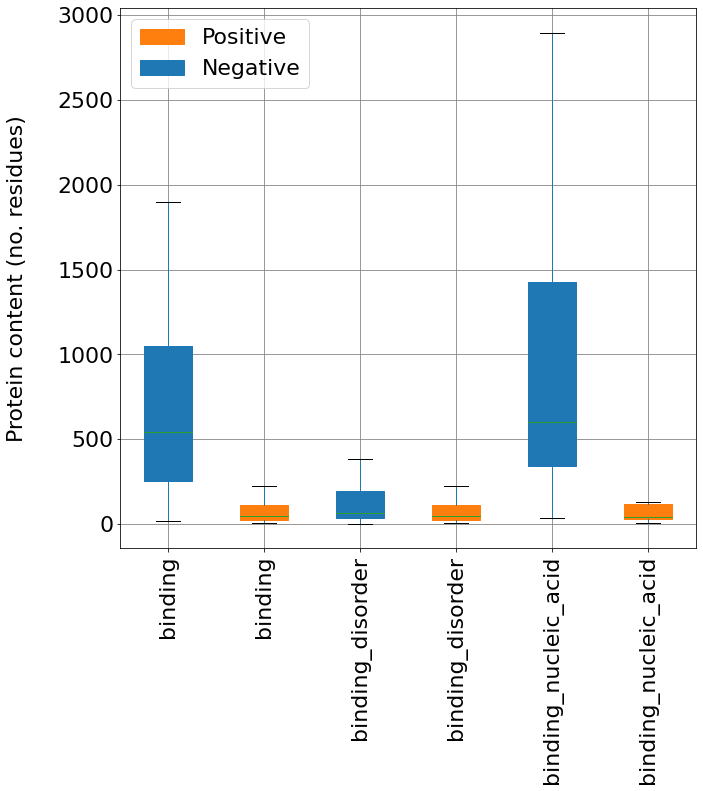

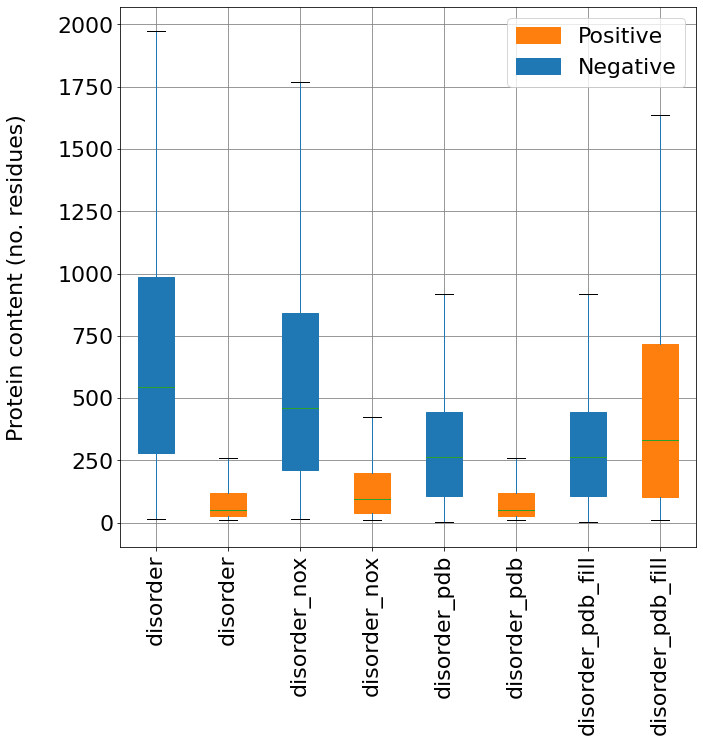

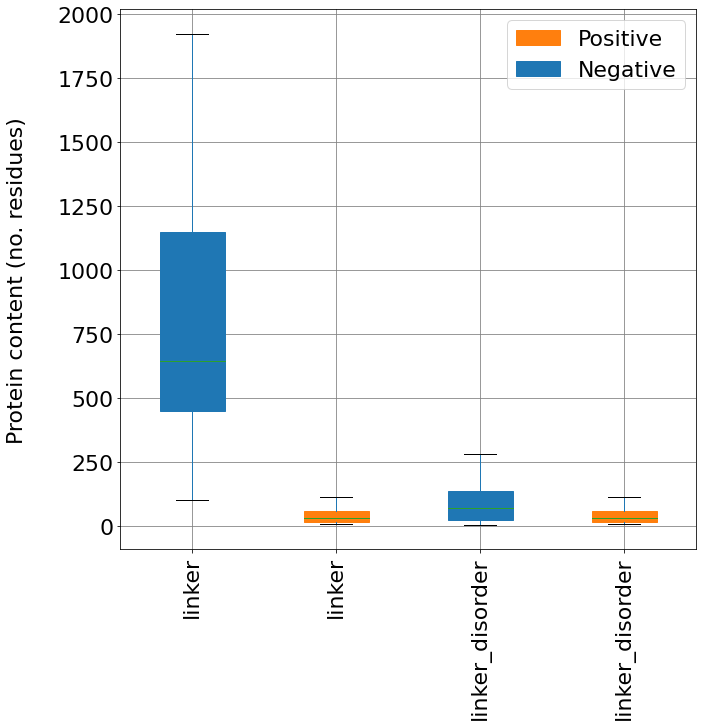

In [9]:
# Content at the protein level
for group, df_g in df_references.reset_index().groupby('group'):
    df_len = df_g.groupby(['disprot_id', 'reference', 'value']).agg({'pos': 'count'}).droplevel('disprot_id').reset_index()
    df_len = df_len.loc[df_len['value'] != '-']
    # print(df_len)

    fig, ax = plt.subplots(figsize=(10, 10))
    bp = df_len.boxplot(by=['reference', 'value'], ax=ax, showfliers=False, return_type='dict', patch_artist=True)
    ax.tick_params(axis='x', labelrotation=90)
    # fill with colors
    colors = {'0': '#1f77b4', '1': '#ff7f0e'}
    for patch, (label, df_g) in zip(bp['pos']['boxes'], df_len.groupby(['reference', 'value'])):
        patch.set_color(colors[label[1]])

    ax.set_ylabel('Protein content (no. residues)', labelpad=30)

    positive = mpatches.Patch(label='Positive', color=colors['1'])
    negative = mpatches.Patch(label='Negative', color=colors['0'])
    ax.legend(handles=[positive, negative])

    labels = [item.get_text()[1:-1].split(",")[0] for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)


    plt.suptitle("")
    plt.title('')
    fig.gca().set_xlabel("")
    fig.savefig("{}/stat_content_{}.png".format(fig_dir, group), dpi=300, bbox_inches='tight')
    # break

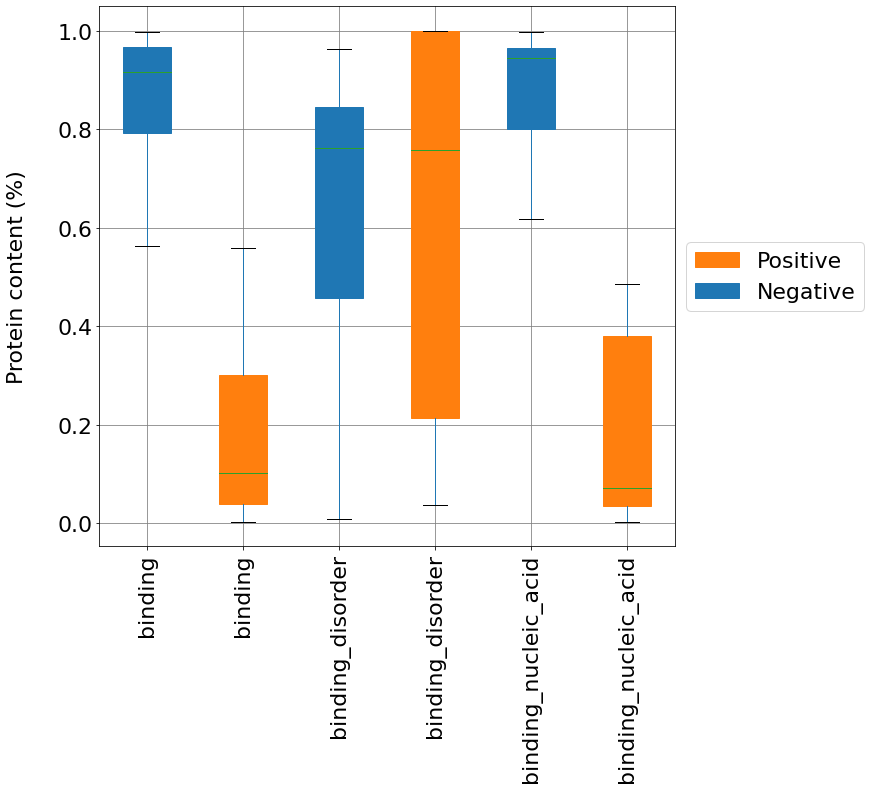

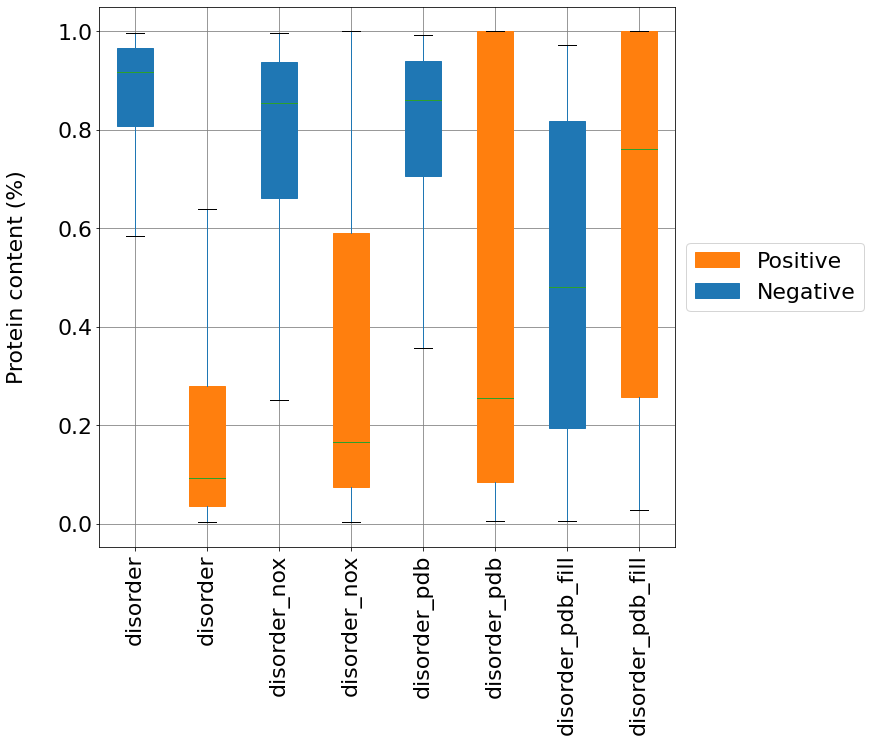

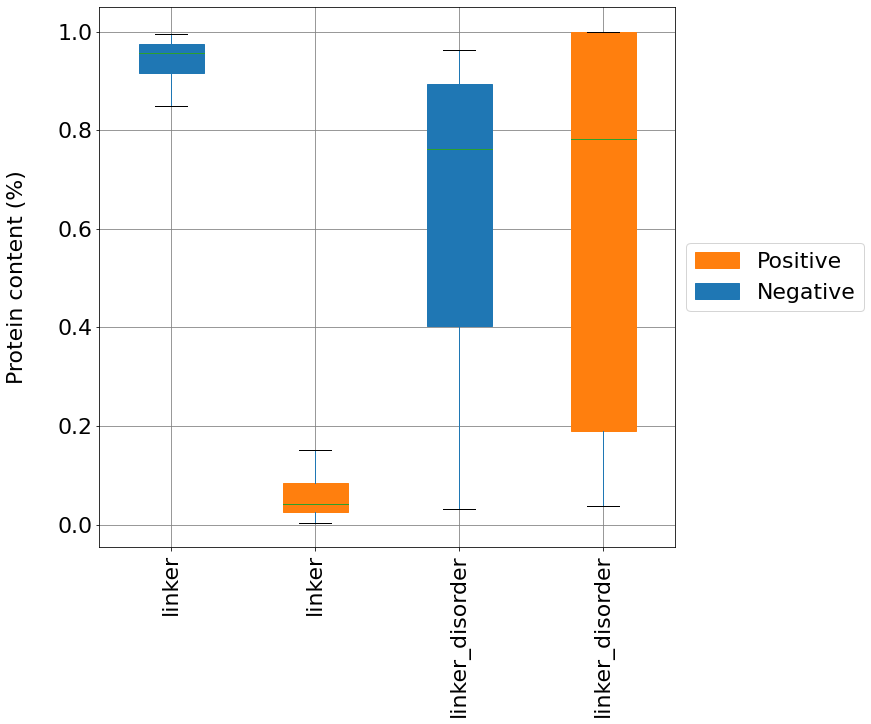

In [10]:
# Content at the protein level
for group, df_g in df_references.reset_index().groupby('group'):
    df_ = df_g.groupby(['disprot_id', 'reference', 'value']).agg({'pos': 'count'}).reset_index()
    df_ = df_.loc[df_['value'] != '-']#.droplevel('disprot_id').reset_index()#.pivot(index='reference', columns='value', values='pos')
    df_tot = df_.groupby(['disprot_id', 'reference']).agg({'pos': 'sum'})
    df_ = pd.merge(df_, df_tot, on=['disprot_id', 'reference'])
    df_['fraction'] = df_['pos_x'] / df_['pos_y']
    # print(df_)

    fig, ax = plt.subplots(figsize=(10, 10))
    bp = df_.loc[:, ['reference', 'value', 'fraction']].boxplot(by=['reference', 'value'], ax=ax, showfliers=False, return_type='dict', patch_artist=True)
    ax.tick_params(axis='x', labelrotation=90)
    # fill with colors
    colors = {'0': '#1f77b4', '1': '#ff7f0e'}
    for patch, (label, df_g) in zip(bp['fraction']['boxes'], df_.groupby(['reference', 'value'])):
        patch.set_color(colors[label[1]])

    ax.set_ylabel('Protein content (%)', labelpad=30)

    positive = mpatches.Patch(label='Positive', color=colors['1'])
    negative = mpatches.Patch(label='Negative', color=colors['0'])
    ax.legend(handles=[positive, negative], loc='center left', bbox_to_anchor=(1.0, 0.5))

    labels = [item.get_text()[1:-1].split(",")[0] for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)

    plt.suptitle("")
    plt.title('')
    fig.gca().set_xlabel("")
    fig.savefig("{}/stat_content_normalized_{}.png".format(fig_dir, group), dpi=300, bbox_inches='tight')

    # break

In [76]:
df_dataset = pd.read_csv(dataset_raw_file, sep="\t")
df_dataset.columns

Index(['region_id', 'unpublished', 'ec_ontology', 'end', 'term_id', 'start',
       'version', 'statement', 'term_name', 'ec_name', 'curator_orcid',
       'released', 'term_ontology', 'curator_name', 'reference_id', 'date',
       'reference_source', 'term_namespace', 'ec_id', 'curator_id',
       'reference_html', 'ec_go', 'disprot_namespace', 'validated.curator_id',
       'validated.timestamp', 'validated.curator_name', 'term_not_annotate',
       'term_is_obsolete', 'term_comment', 'term_def', 'term_is_binding',
       'interaction_partner', 'cross_refs', 'confidence', 'sample',
       'term_xref', 'construct_alterations', 'sequence_construct',
       'term_go_domain', 'states_connection', 'conditions',
       'annotation_extensions', 'disprot_id', 'acc', 'ncbi_taxon_id',
       'organism', 'sequence', 'challenge'],
      dtype='object')

In [77]:
def expand_region(df_:pd.DataFrame, start_col:str='start', end_col:str='end', res_col:str='reg_position') -> pd.DataFrame:
    df_[res_col] = list(range(int(df_[start_col]), int(df_[end_col]) + 1, 1))
    return df_

In [78]:
df_pos = df_dataset.apply(expand_region, axis=1).explode("reg_position")
df_pos

,region_id,unpublished,ec_ontology,end,term_id,start,version,statement,term_name,ec_name,...,states_connection,conditions,annotation_extensions,disprot_id,acc,ncbi_taxon_id,organism,sequence,challenge,reg_position
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,NaN,NaN,NaN,DP02342,P06837,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,1
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,NaN,NaN,NaN,DP02342,P06837,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,2
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,NaN,NaN,NaN,DP02342,P06837,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,3
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,NaN,NaN,NaN,DP02342,P06837,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,4
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,NaN,NaN,NaN,DP02342,P06837,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,DP03739r012,True,ECO,417,GO:0005516,390,0,"[{'text': 'However, on addition of Calmodulin,...",calmodulin binding,nuclear magnetic resonance spectroscopy eviden...,...,NaN,NaN,NaN,DP03739,P24588,9606,Homo sapiens,METTISEIHVENKDEKRSAEGSPGAERQKEKASMLCFKRRKKAAKA...,binding protein,413
1099,DP03739r012,True,ECO,417,GO:0005516,390,0,"[{'text': 'However, on addition of Calmodulin,...",calmodulin binding,nuclear magnetic resonance spectroscopy eviden...,...,NaN,NaN,NaN,DP03739,P24588,9606,Homo sapiens,METTISEIHVENKDEKRSAEGSPGAERQKEKASMLCFKRRKKAAKA...,binding protein,414
1099,DP03739r012,True,ECO,417,GO:0005516,390,0,"[{'text': 'However, on addition of Calmodulin,...",calmodulin binding,nuclear magnetic resonance spectroscopy eviden...,...,NaN,NaN,NaN,DP03739,P24588,9606,Homo sapiens,METTISEIHVENKDEKRSAEGSPGAERQKEKASMLCFKRRKKAAKA...,binding protein,415
1099,DP03739r012,True,ECO,417,GO:0005516,390,0,"[{'text': 'However, on addition of Calmodulin,...",calmodulin binding,nuclear magnetic resonance spectroscopy eviden...,...,NaN,NaN,NaN,DP03739,P24588,9606,Homo sapiens,METTISEIHVENKDEKRSAEGSPGAERQKEKASMLCFKRRKKAAKA...,binding protein,416


In [79]:
df_ec = pd.merge(df_pos.groupby(['challenge', 'ec_name'], as_index=False)['reg_position'].nunique(), df_pos.groupby(['challenge'], as_index=False)['reg_position'].nunique(), on='challenge').rename({'reg_position_x': 'count', 'reg_position_y': 'total'}, axis=1).sort_values(by=['challenge', 'count'], ascending=[True, True])
df_ec['fraction'] = df_ec['count'] / df_ec['total']
df_ec

,challenge,ec_name,count,total,fraction
23,binding,luciferase reporter gene assay evidence used i...,11,2037,0.005400
32,binding,qualitative western immunoblotting evidence us...,11,2037,0.005400
31,binding,protein kinase assay evidence used in manual a...,12,2037,0.005891
11,binding,deletion mutation phenotypic evidence used in ...,20,2037,0.009818
5,binding,co-immunoprecipitation evidence used in manual...,21,2037,0.010309
...,...,...,...,...,...
136,transition,nuclear magnetic resonance spectroscopy eviden...,415,964,0.430498
127,transition,analytical ultracentrifugation evidence used i...,497,964,0.515560
128,transition,chromatography evidence used in manual assertion,497,964,0.515560
139,transition,x-ray crystallography evidence used in manual ...,529,964,0.548755


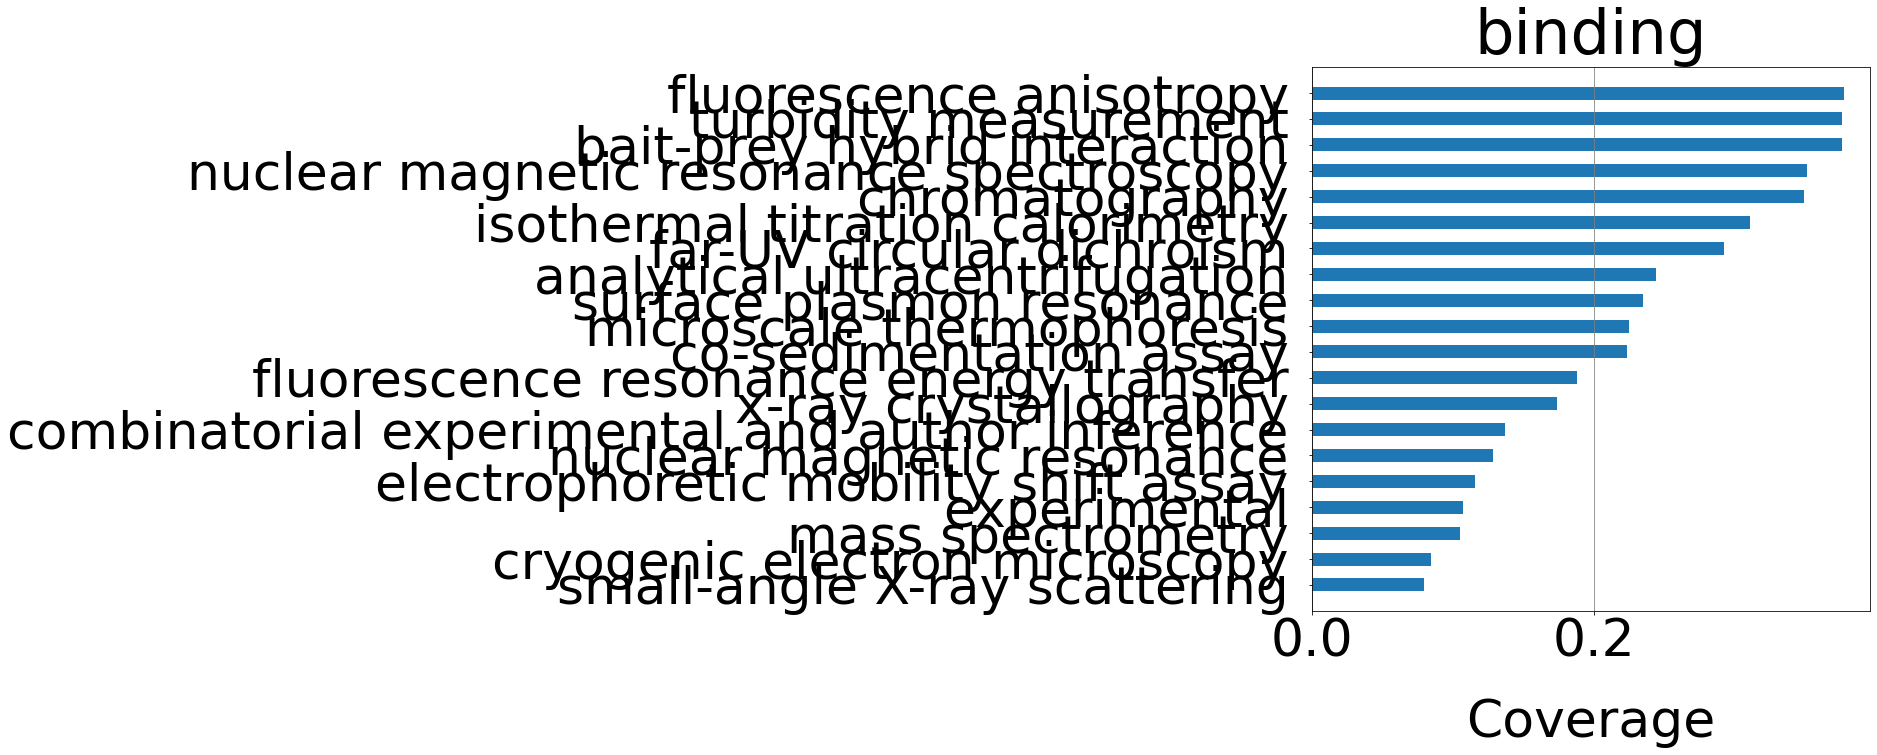

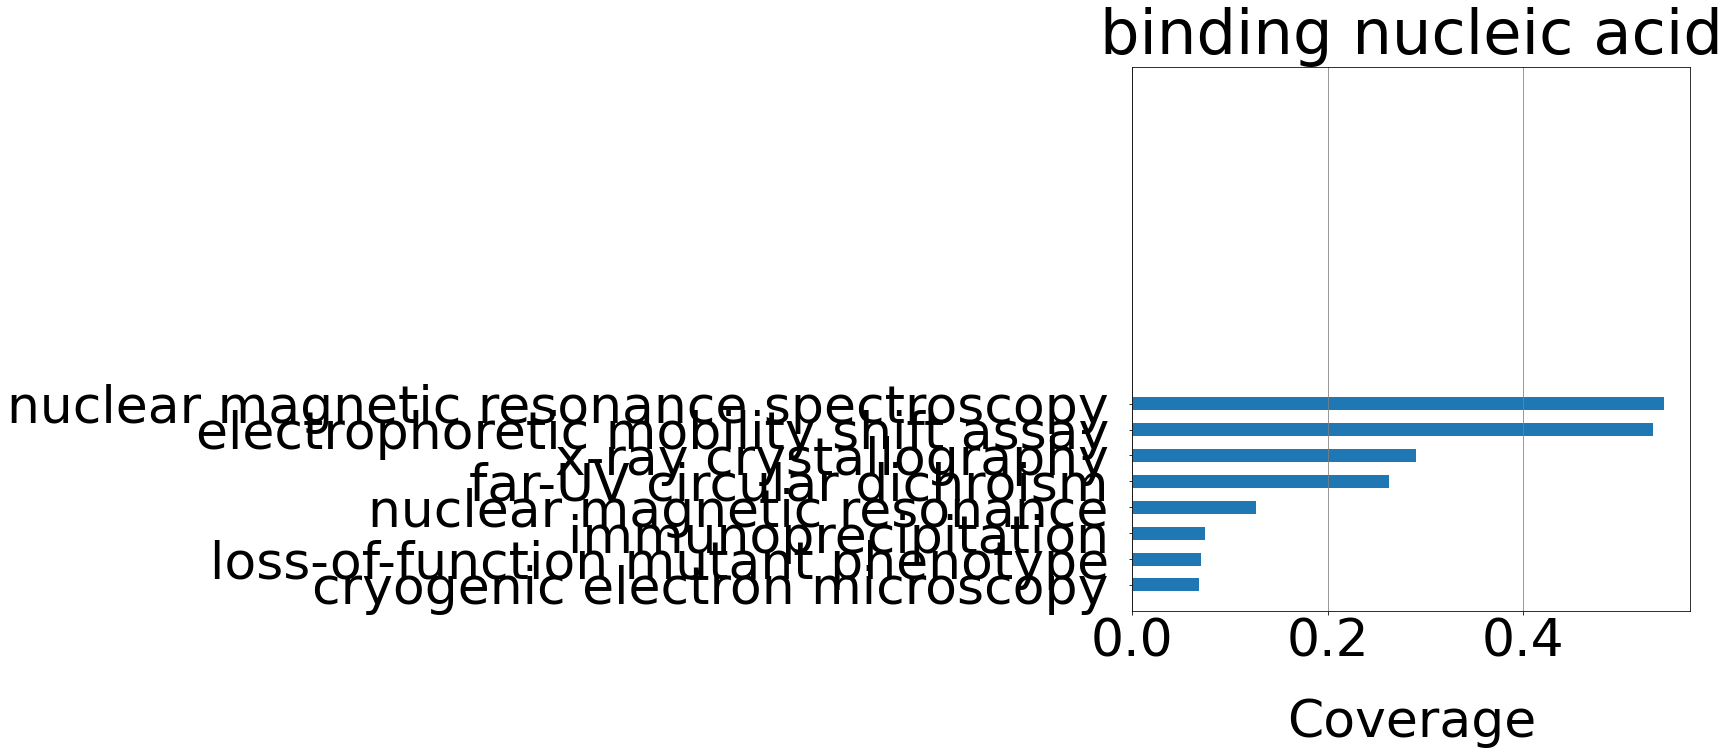

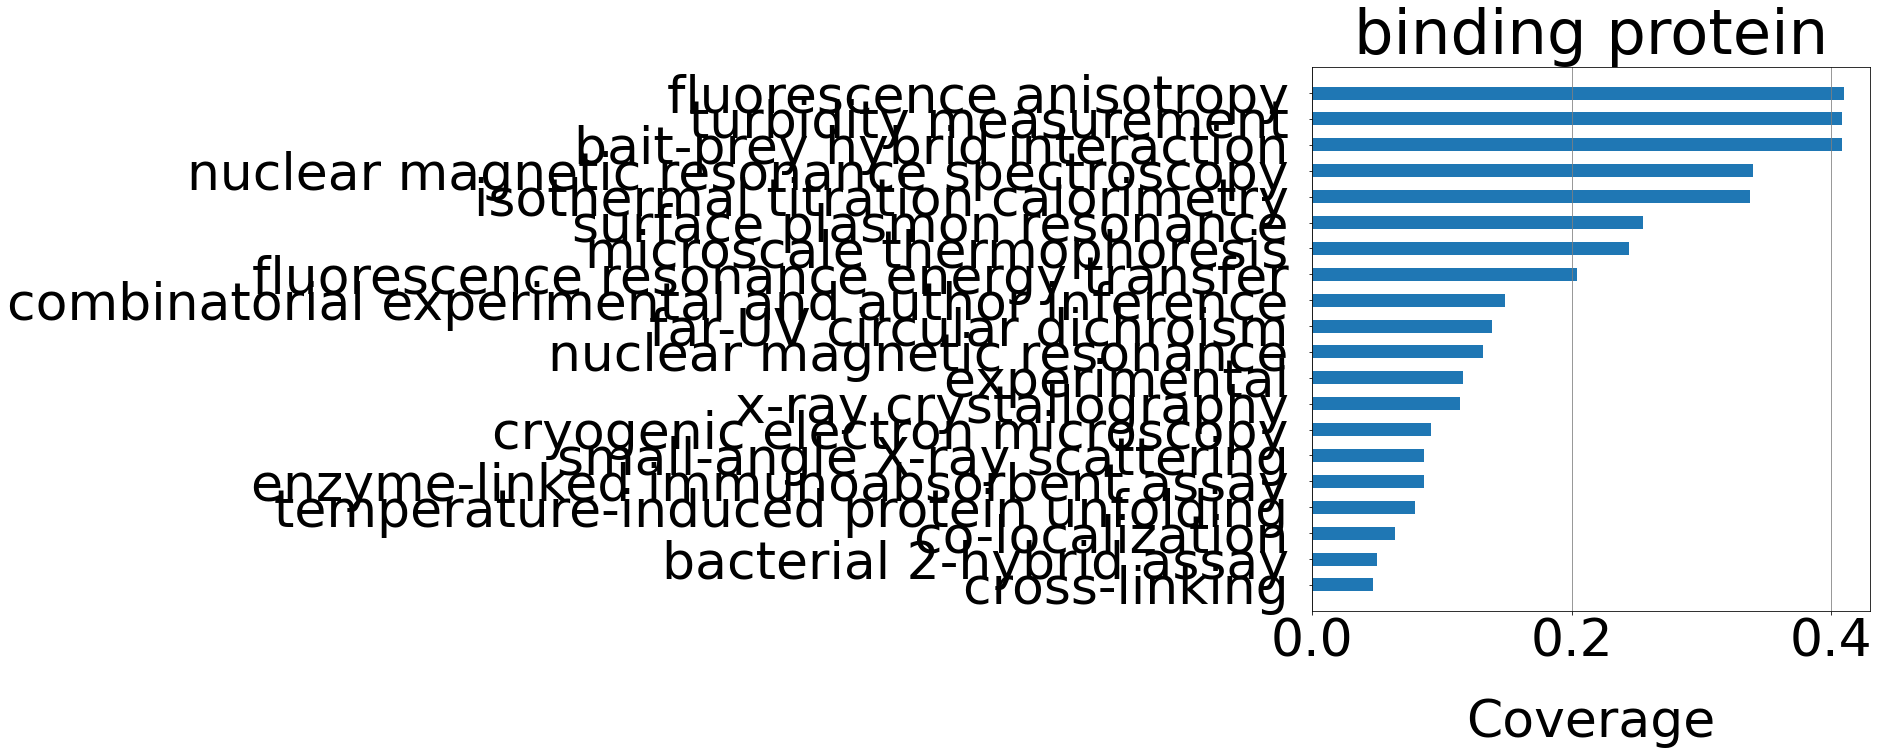

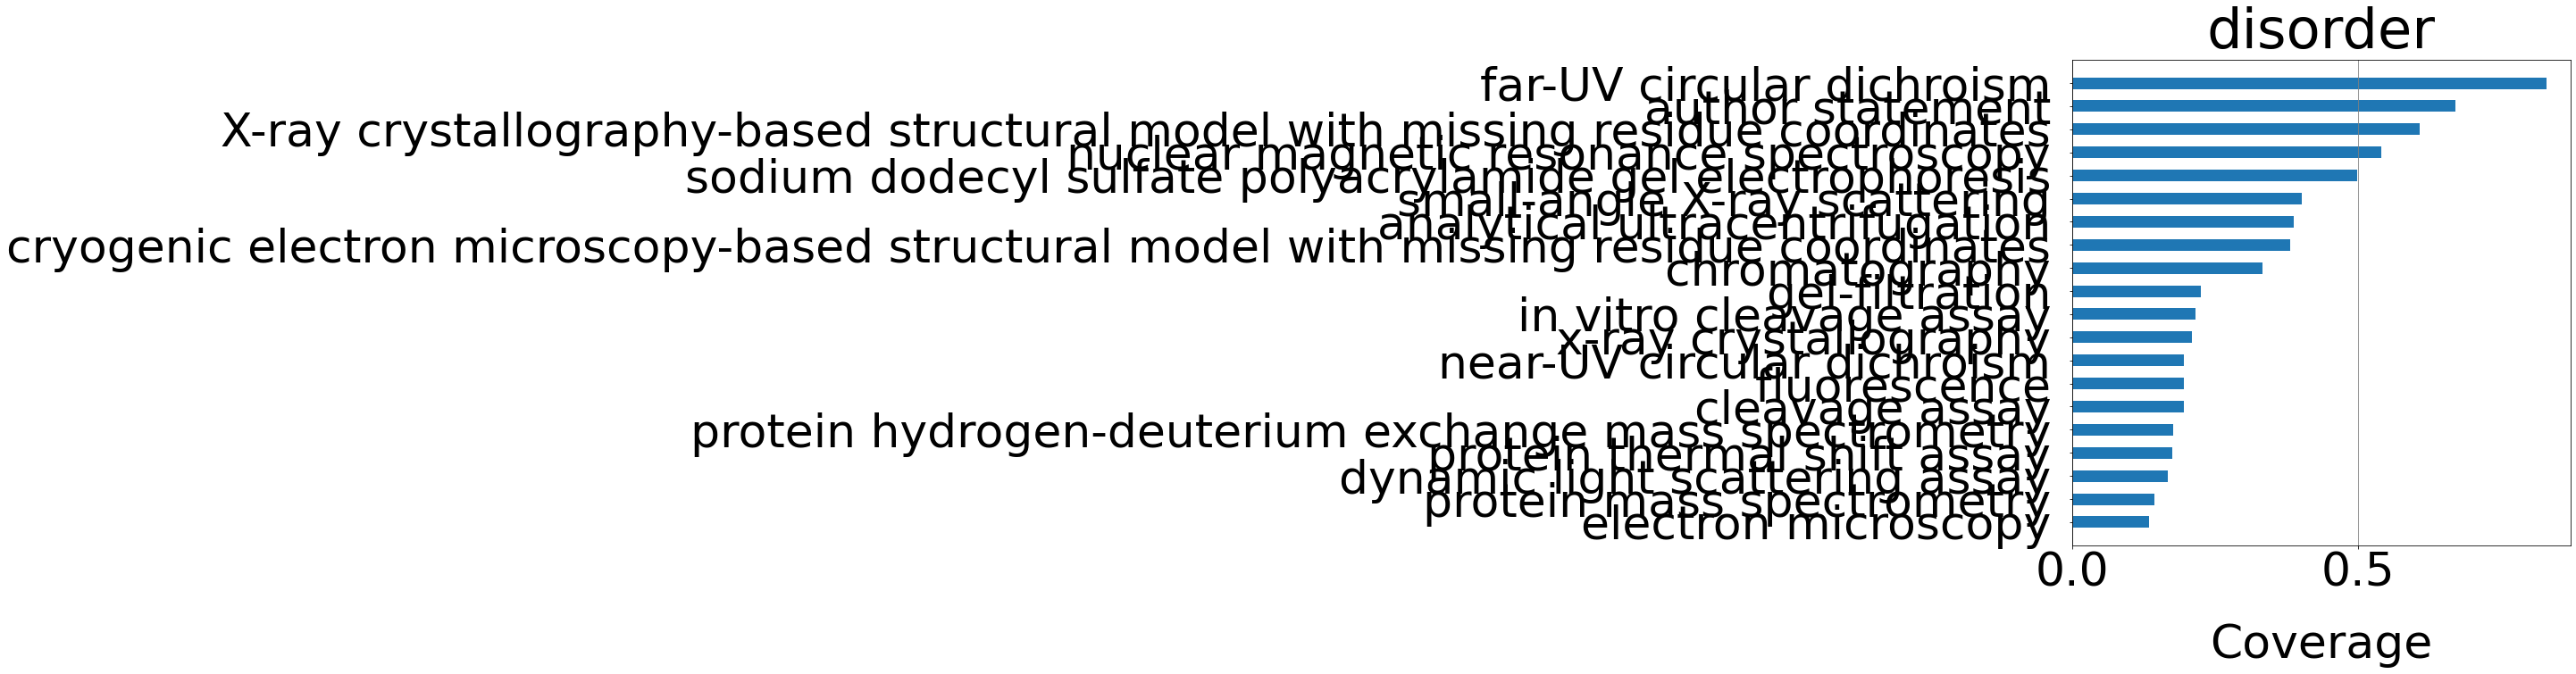

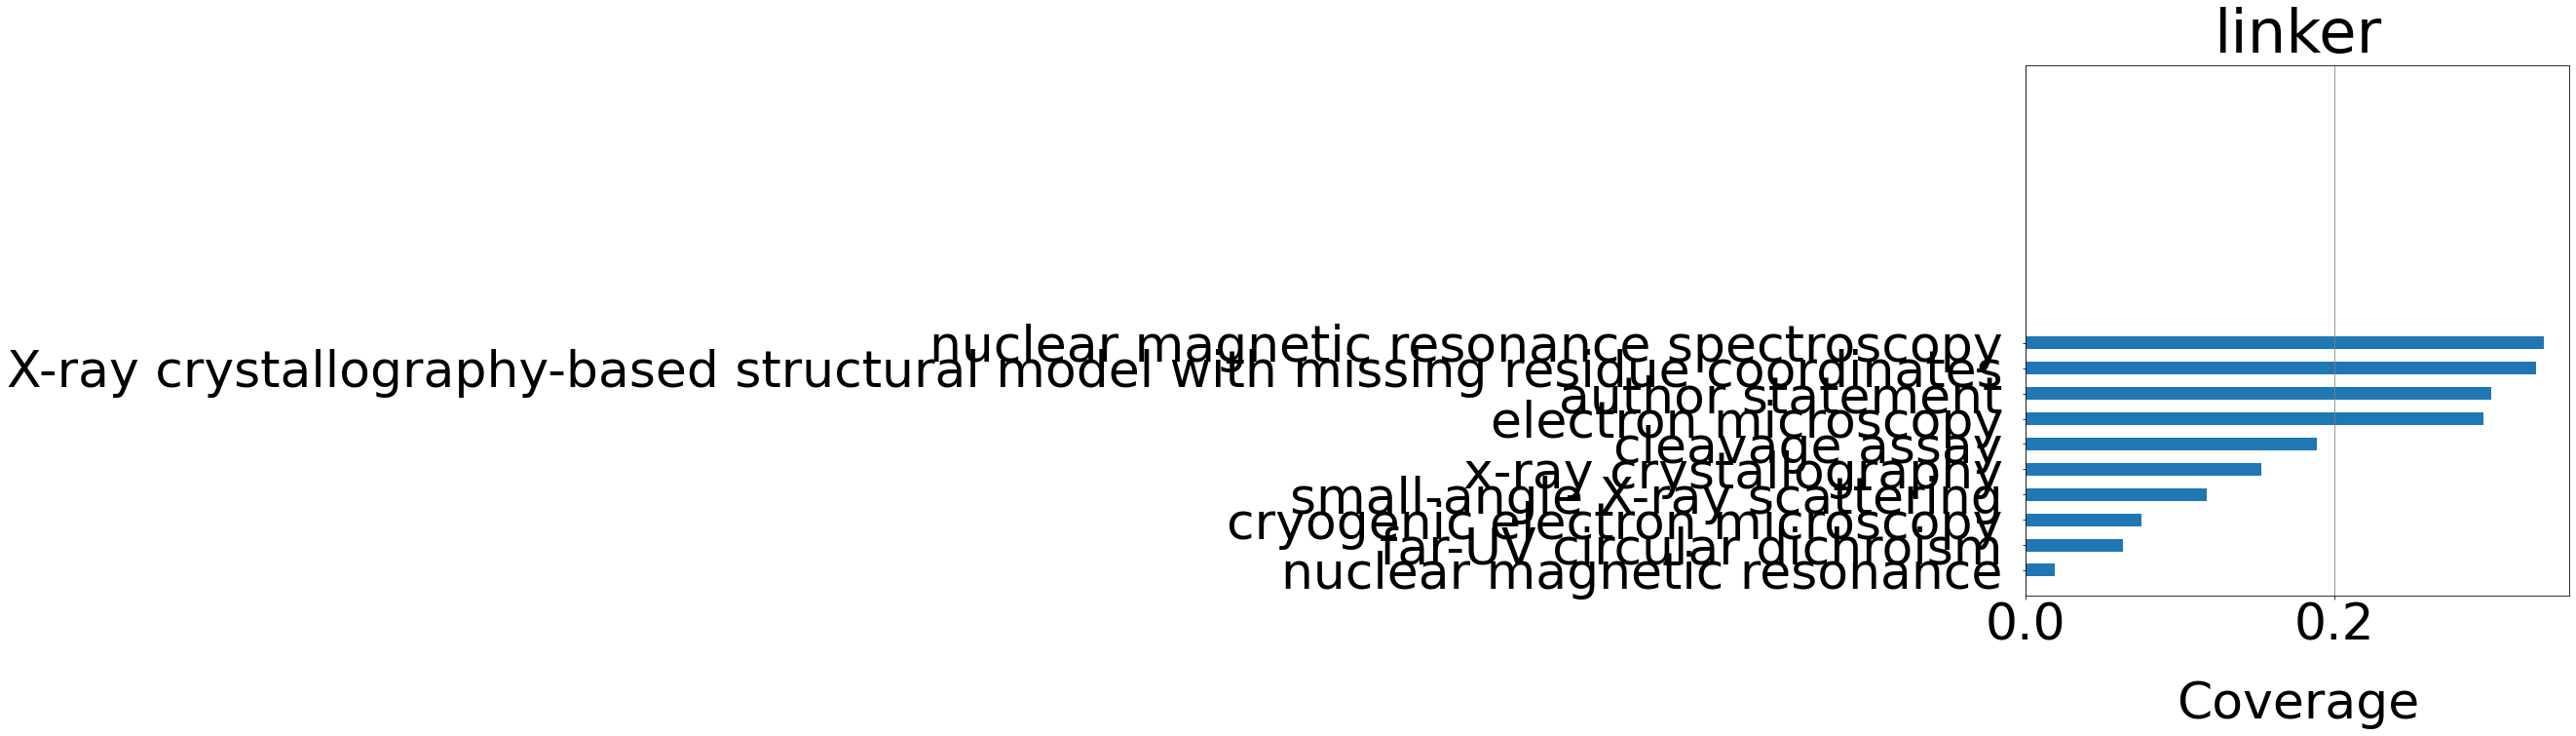

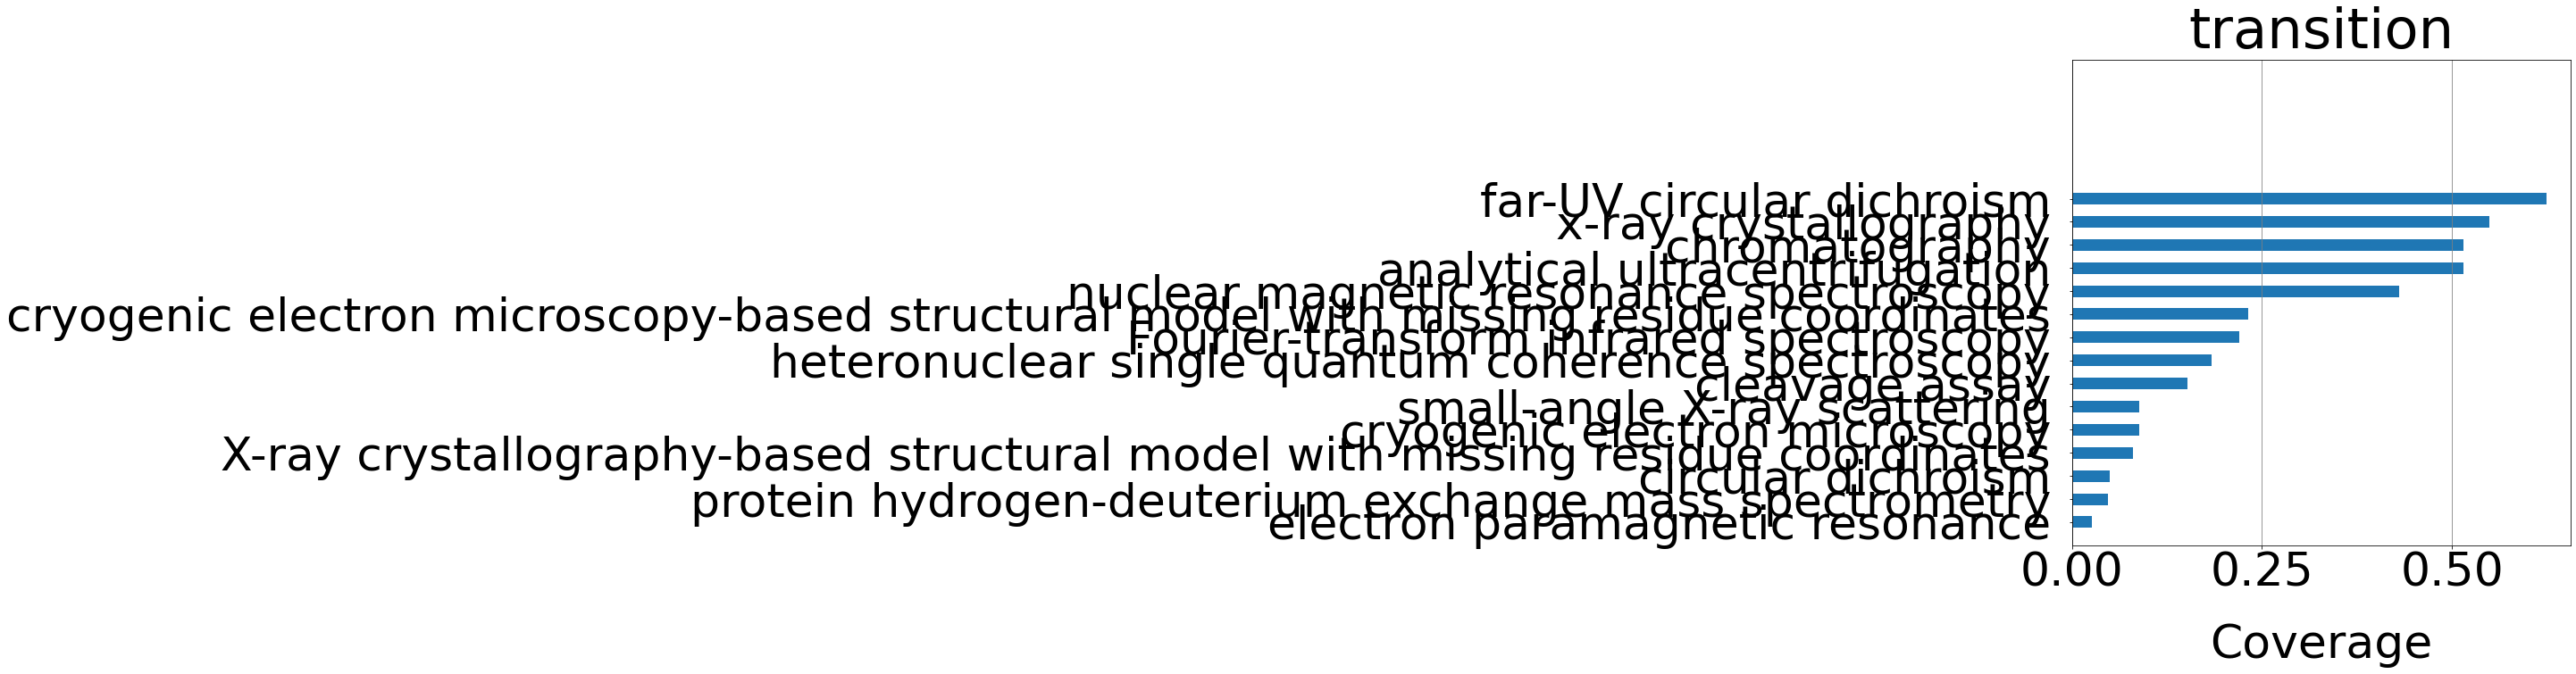

In [111]:
for challenge, df_g in df_ec.groupby('challenge'):
    fig, ax = plt.subplots(figsize=(10, 10))
    df_g['ec_name'] = df_g['ec_name'].map(lambda x: x.split('evidence')[0].split('used')[0])
    df_g.set_index('ec_name')['fraction'].iloc[-20:].plot(kind='barh', ax=ax)
    ax.xaxis.grid()
    ax.set_xlabel('Coverage', labelpad=30)

    plt.title(challenge)
    fig.gca().set_ylabel("")
    ax.set_ybound(-1, 20)

    fig.gca().set_ylabel("")
    fig.savefig("{}/stat_ec_{}.png".format(fig_dir, challenge), dpi=300, bbox_inches='tight')
    # break

In [81]:
# ftp://ftp.ncbi.nih.gov/pub/taxonomy/new_taxdump
df_tax = pd.read_csv(ncbi_tax_file, sep="|", header=0, names=['id', '0', '1', '2', '3', '4', '5'], usecols=[0,3,4,5,6,7,9])
for i in df_tax.columns:
    if df_tax[i].dtype == 'object':
        df_tax[i] = df_tax[i].map(str.strip)
df_tax

,id,0,1,2,3,4,5
0,131567,,,,,,
1,2157,,,,,,
2,1935183,,,,,,Archaea
3,2798909,,,,,,Archaea
4,2798916,,,,,Candidatus Baldrarchaeota,Archaea
...,...,...,...,...,...,...,...
2470427,2413,,,,,,
2470428,2417,,,,,,
2470429,2414,,,,,,
2470430,2415,,,,,,


In [82]:
df_tax.loc[df_tax['id'] == 9606]

,id,0,1,2,3,4,5
813598,9606,Homo,Hominidae,Primates,Mammalia,Chordata,Eukaryota


In [83]:
df_ = pd.merge(df_dataset, df_tax, left_on='ncbi_taxon_id', right_on='id', how='left')
df_

,region_id,unpublished,ec_ontology,end,term_id,start,version,statement,term_name,ec_name,...,organism,sequence,challenge,id,0,1,2,3,4,5
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,10090,Mus,Muridae,Rodentia,Mammalia,Chordata,Eukaryota
1,DP02342r009,True,ECO,227,IDPO:00078,1,2,"[{'text': ""The NMR spectra of full-length Nm a...",pre-molten globule,nuclear magnetic resonance spectroscopy eviden...,...,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,10090,Mus,Muridae,Rodentia,Mammalia,Chordata,Eukaryota
2,DP03000r002,True,ECO,456,IDPO:00078,1,3,[{'text': 'The experimentally observed values ...,pre-molten globule,chromatography evidence used in manual assertion,...,Nipah virus,MDKLELVNDGLNIIDFIQKNQKEIQKTYGRSSIQQPSIKDQTKAWE...,disorder,121791,Henipavirus,Paramyxoviridae,Mononegavirales,Monjiviricetes,Negarnaviricota,Viruses
3,DP03000r003,True,ECO,456,IDPO:00078,1,3,[{'text': 'The spectra are typical of proteins...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,Nipah virus,MDKLELVNDGLNIIDFIQKNQKEIQKTYGRSSIQQPSIKDQTKAWE...,disorder,121791,Henipavirus,Paramyxoviridae,Mononegavirales,Monjiviricetes,Negarnaviricota,Viruses
4,DP03001r002,True,ECO,457,IDPO:00078,1,2,[{'text': 'The experimentally observed values ...,pre-molten globule,chromatography evidence used in manual assertion,...,Hendra virus (isolate Horse/Autralia/Hendra/1994),MDKLDLVNDGLDIIDFIQKNQKEIQKTYGRSSIQQPSTKDRTRAWE...,disorder,928303,Henipavirus,Paramyxoviridae,Mononegavirales,Monjiviricetes,Negarnaviricota,Viruses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,DP03708r005,True,ECO,86,GO:0042803,41,0,[{'text': 'Interactions between 6xHis thioredo...,protein homodimerization activity,glutathione S-transferase pull-down assay evid...,...,Drosophila melanogaster,MEDLTKNIIFTNAINGQPATIQYQTADGTILKQPKIEGQKTEQQPT...,binding protein,7227,Drosophila,Drosophilidae,Diptera,Insecta,Arthropoda,Eukaryota
1096,DP03708r006,True,ECO,86,GO:0042803,1,0,[{'text': 'SAXS provides precise information a...,protein homodimerization activity,small-angle X-ray scattering evidence used in ...,...,Drosophila melanogaster,MEDLTKNIIFTNAINGQPATIQYQTADGTILKQPKIEGQKTEQQPT...,binding,7227,Drosophila,Drosophilidae,Diptera,Insecta,Arthropoda,Eukaryota
1097,DP03708r006,True,ECO,86,GO:0042803,1,0,[{'text': 'SAXS provides precise information a...,protein homodimerization activity,small-angle X-ray scattering evidence used in ...,...,Drosophila melanogaster,MEDLTKNIIFTNAINGQPATIQYQTADGTILKQPKIEGQKTEQQPT...,binding protein,7227,Drosophila,Drosophilidae,Diptera,Insecta,Arthropoda,Eukaryota
1098,DP03739r012,True,ECO,417,GO:0005516,390,0,"[{'text': 'However, on addition of Calmodulin,...",calmodulin binding,nuclear magnetic resonance spectroscopy eviden...,...,Homo sapiens,METTISEIHVENKDEKRSAEGSPGAERQKEKASMLCFKRRKKAAKA...,binding,9606,Homo,Hominidae,Primates,Mammalia,Chordata,Eukaryota


In [89]:
df_g = df_.loc[:, ['challenge', 'disprot_id', '5']].drop_duplicates().groupby(['challenge', '5']).count().sort_values(by=['challenge','5'])
# df_g = df_g.reset_index().pivot(index='5', columns='challenge', values='disprot_id').loc[:, ['disorder', 'linker', 'binding']]
df_g = df_g.reset_index().pivot(index='5', columns='challenge', values='disprot_id').loc[:, ['disorder', 'binding']]
df_g

challenge,disorder,binding
5,,
Bacteria,43.0,11.0
Eukaryota,283.0,57.0
Viruses,22.0,10.0


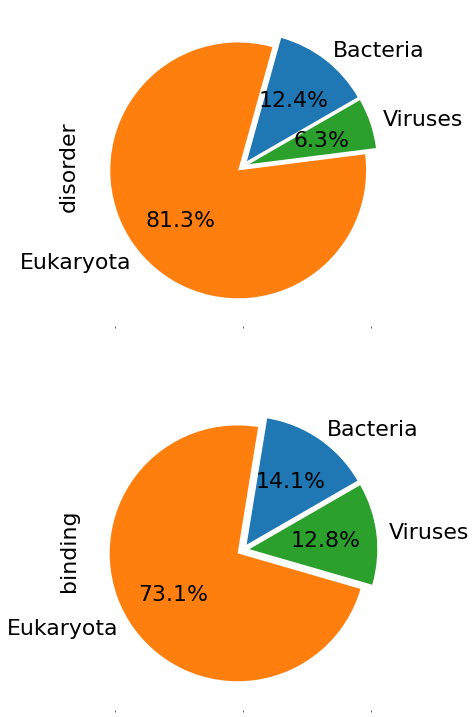

In [90]:
plot = df_g.plot.pie(subplots=True, figsize=(10, 20), explode=(0.05, 0.05, 0.05), legend=False, layout=(3,1), autopct='%1.1f%%', startangle=30)
plt.savefig("{}/stat_tax.png".format(fig_dir), dpi=300, bbox_inches='tight')

In [86]:
df = pd.read_csv(datase_file, sep="\t")
df

,disprot_id,acc,pos,aa,disorder,linker,transition,binding nucleic acid,binding,binding protein,disorder_nox,pdb
0,DP02342,P06837,1,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,DP02342,P06837,2,L,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,DP02342,P06837,3,C,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,DP02342,P06837,4,C,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,DP02342,P06837,5,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
287015,DP02544,Q04410,368,Q,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
287016,DP02544,Q04410,369,S,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
287017,DP02544,Q04410,370,S,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
287018,DP02544,Q04410,371,S,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN


/home/damiano/miniconda3/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


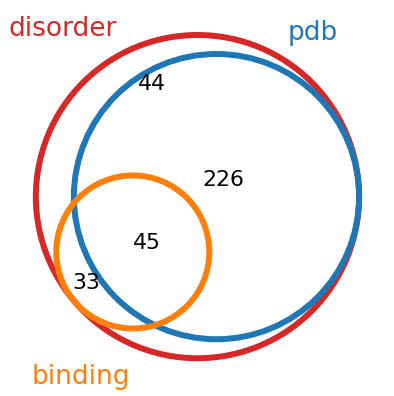

In [87]:
# https://towardsdatascience.com/professional-venn-diagrams-in-python-638abfff39cc
from matplotlib_venn import venn3, venn3_circles

colors = ['#D72828', '#2077B5', '#FF7F0D']
labels = ['disorder', 'pdb', 'binding']
sets = [set(df.loc[df[label].notnull(), 'disprot_id']) for label in labels]

plt.figure(figsize=(7, 7))
v = venn3(subsets=sets, set_labels=labels, alpha=.0)

for i, (text, pos) in enumerate(zip(v.set_labels, [(1, 1), (1, 1.1), (1.8, 1.2)])):
    x, y = text.get_position()
    # print(text, x, y)
    text.set_position((x * pos[0], y * pos[1]))
    text.set_color(colors[i])

circles = venn3_circles(subsets=sets)
for color, circle in zip(colors, circles):
    circle.set_edgecolor(color)
    circle.set_linewidth(6)

plt.savefig("{}/stat_venn.png".format(fig_dir), dpi=300, bbox_inches='tight')

In [ ]:
# TODO
# statistics of fully disordered proteins

['binding' 'disorder_nox' 'disorder_pdb']


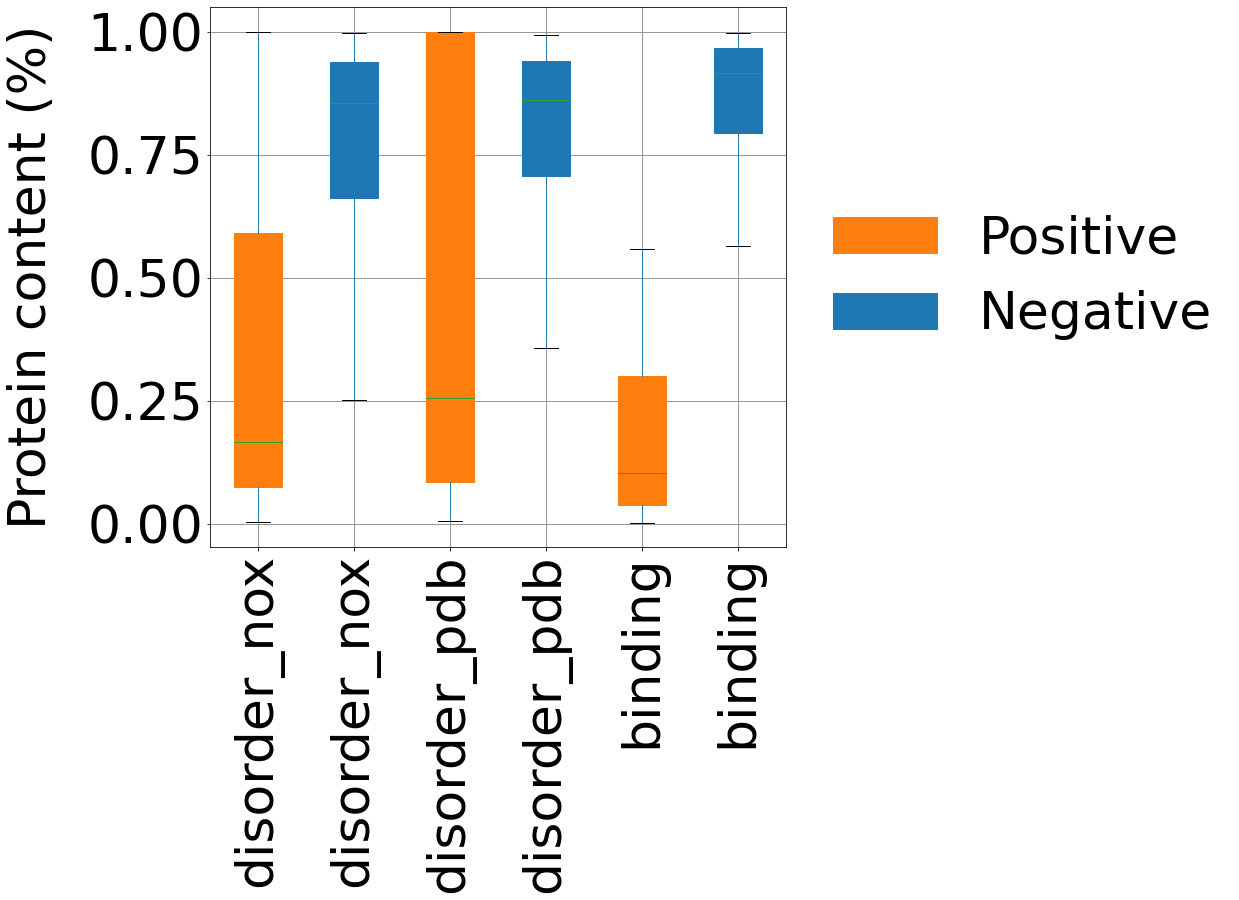

In [106]:
# Paper figure disorder content

plt.rcParams.update({'font.size': 52, 'savefig.transparent': True})

references = ['disorder_nox', 'disorder_pdb', 'binding']
df_g = df_references.reset_index().set_index('reference')
df_g = df_g.loc[references]
df_ = df_g.groupby(['disprot_id', 'reference', 'value']).agg({'pos': 'count'}).reset_index()
df_ = df_.loc[df_['value'] != '-']#.droplevel('disprot_id').reset_index()#.pivot(index='reference', columns='value', values='pos')
df_tot = df_.groupby(['disprot_id', 'reference']).agg({'pos': 'sum'})
df_ = pd.merge(df_, df_tot, on=['disprot_id', 'reference'])
df_['fraction'] = df_['pos_x'] / df_['pos_y']
print(df_['reference'].unique())

fig, ax = plt.subplots(figsize=(10, 10))
bp = df_.loc[:, ['reference', 'value', 'fraction']].boxplot(by=['reference', 'value'], positions=[5,4,1,0,3,2], ax=ax, showfliers=False, return_type='dict', patch_artist=True)
ax.tick_params(axis='x', labelrotation=90)
# fill with colors
colors = {'0': '#1f77b4', '1': '#ff7f0e'}
for patch, (label, df_g) in zip(bp['fraction']['boxes'], df_.groupby(['reference', 'value'])):
    patch.set_color(colors[label[1]])

ax.set_ylabel('Protein content (%)', labelpad=30)

positive = mpatches.Patch(label='Positive', color=colors['1'])
negative = mpatches.Patch(label='Negative', color=colors['0'])
ax.legend(handles=[positive, negative], loc='center left', bbox_to_anchor=(1, .5), frameon=False)

labels = [item.get_text()[1:-1].split(",")[0] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)

plt.suptitle("")
plt.title('')
fig.gca().set_xlabel("")
fig.savefig("{}/stat_content_normalized_paper.png".format(fig_dir), dpi=300, bbox_inches='tight')

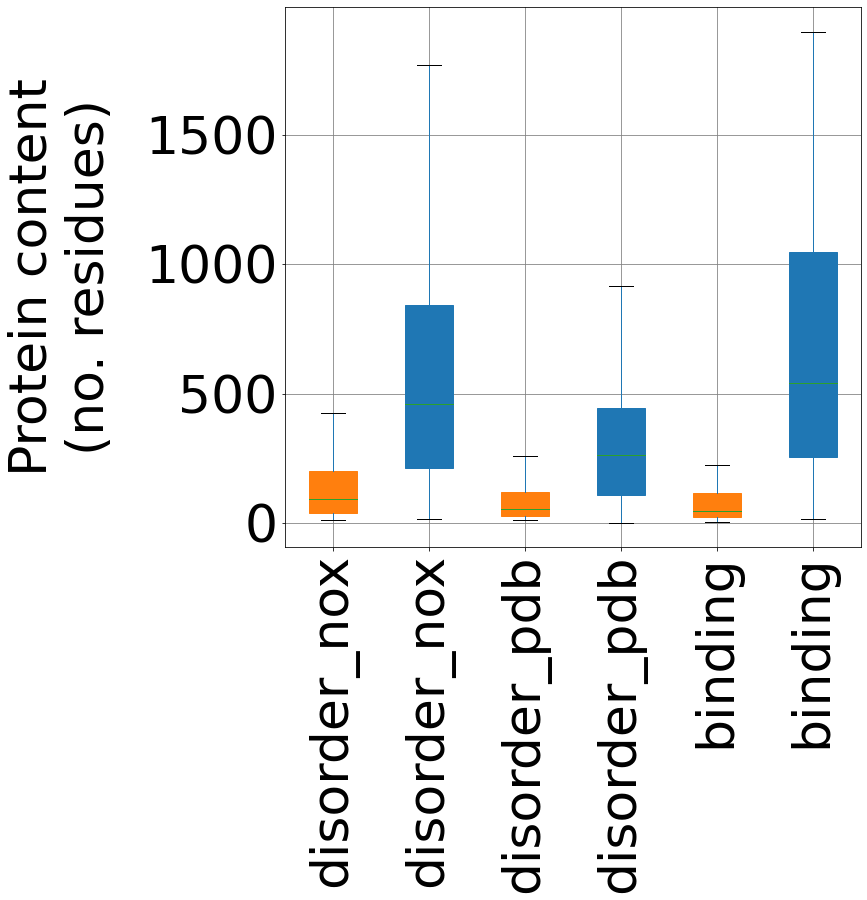

In [108]:
# Content at the protein level
references = ['disorder_nox', 'disorder_pdb', 'binding']
df_g = df_references.reset_index().set_index('reference')
df_g = df_g.loc[references]
df_len = df_g.groupby(['disprot_id', 'reference', 'value']).agg({'pos': 'count'}).droplevel('disprot_id').reset_index()
df_len = df_len.loc[df_len['value'] != '-']
# print(df_len)

fig, ax = plt.subplots(figsize=(10, 10))
bp = df_len.boxplot(by=['reference', 'value'], ax=ax, positions=[5,4,1,0,3,2], showfliers=False, return_type='dict', patch_artist=True)
ax.tick_params(axis='x', labelrotation=90)
# fill with colors
colors = {'0': '#1f77b4', '1': '#ff7f0e'}
for patch, (label, df_g) in zip(bp['pos']['boxes'], df_len.groupby(['reference', 'value'])):
    patch.set_color(colors[label[1]])

ax.set_ylabel('Protein content\n(no. residues)', labelpad=30)

positive = mpatches.Patch(label='Positive', color=colors['1'])
negative = mpatches.Patch(label='Negative', color=colors['0'])
# ax.legend(handles=[positive, negative], loc='center left', bbox_to_anchor=(-.4, 1.2), ncol=2, frameon=False)

labels = [item.get_text()[1:-1].split(",")[0] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)


plt.suptitle("")
plt.title('')
fig.gca().set_xlabel("")
fig.savefig("{}/stat_content_paper.png".format(fig_dir), dpi=300, bbox_inches='tight')
# break

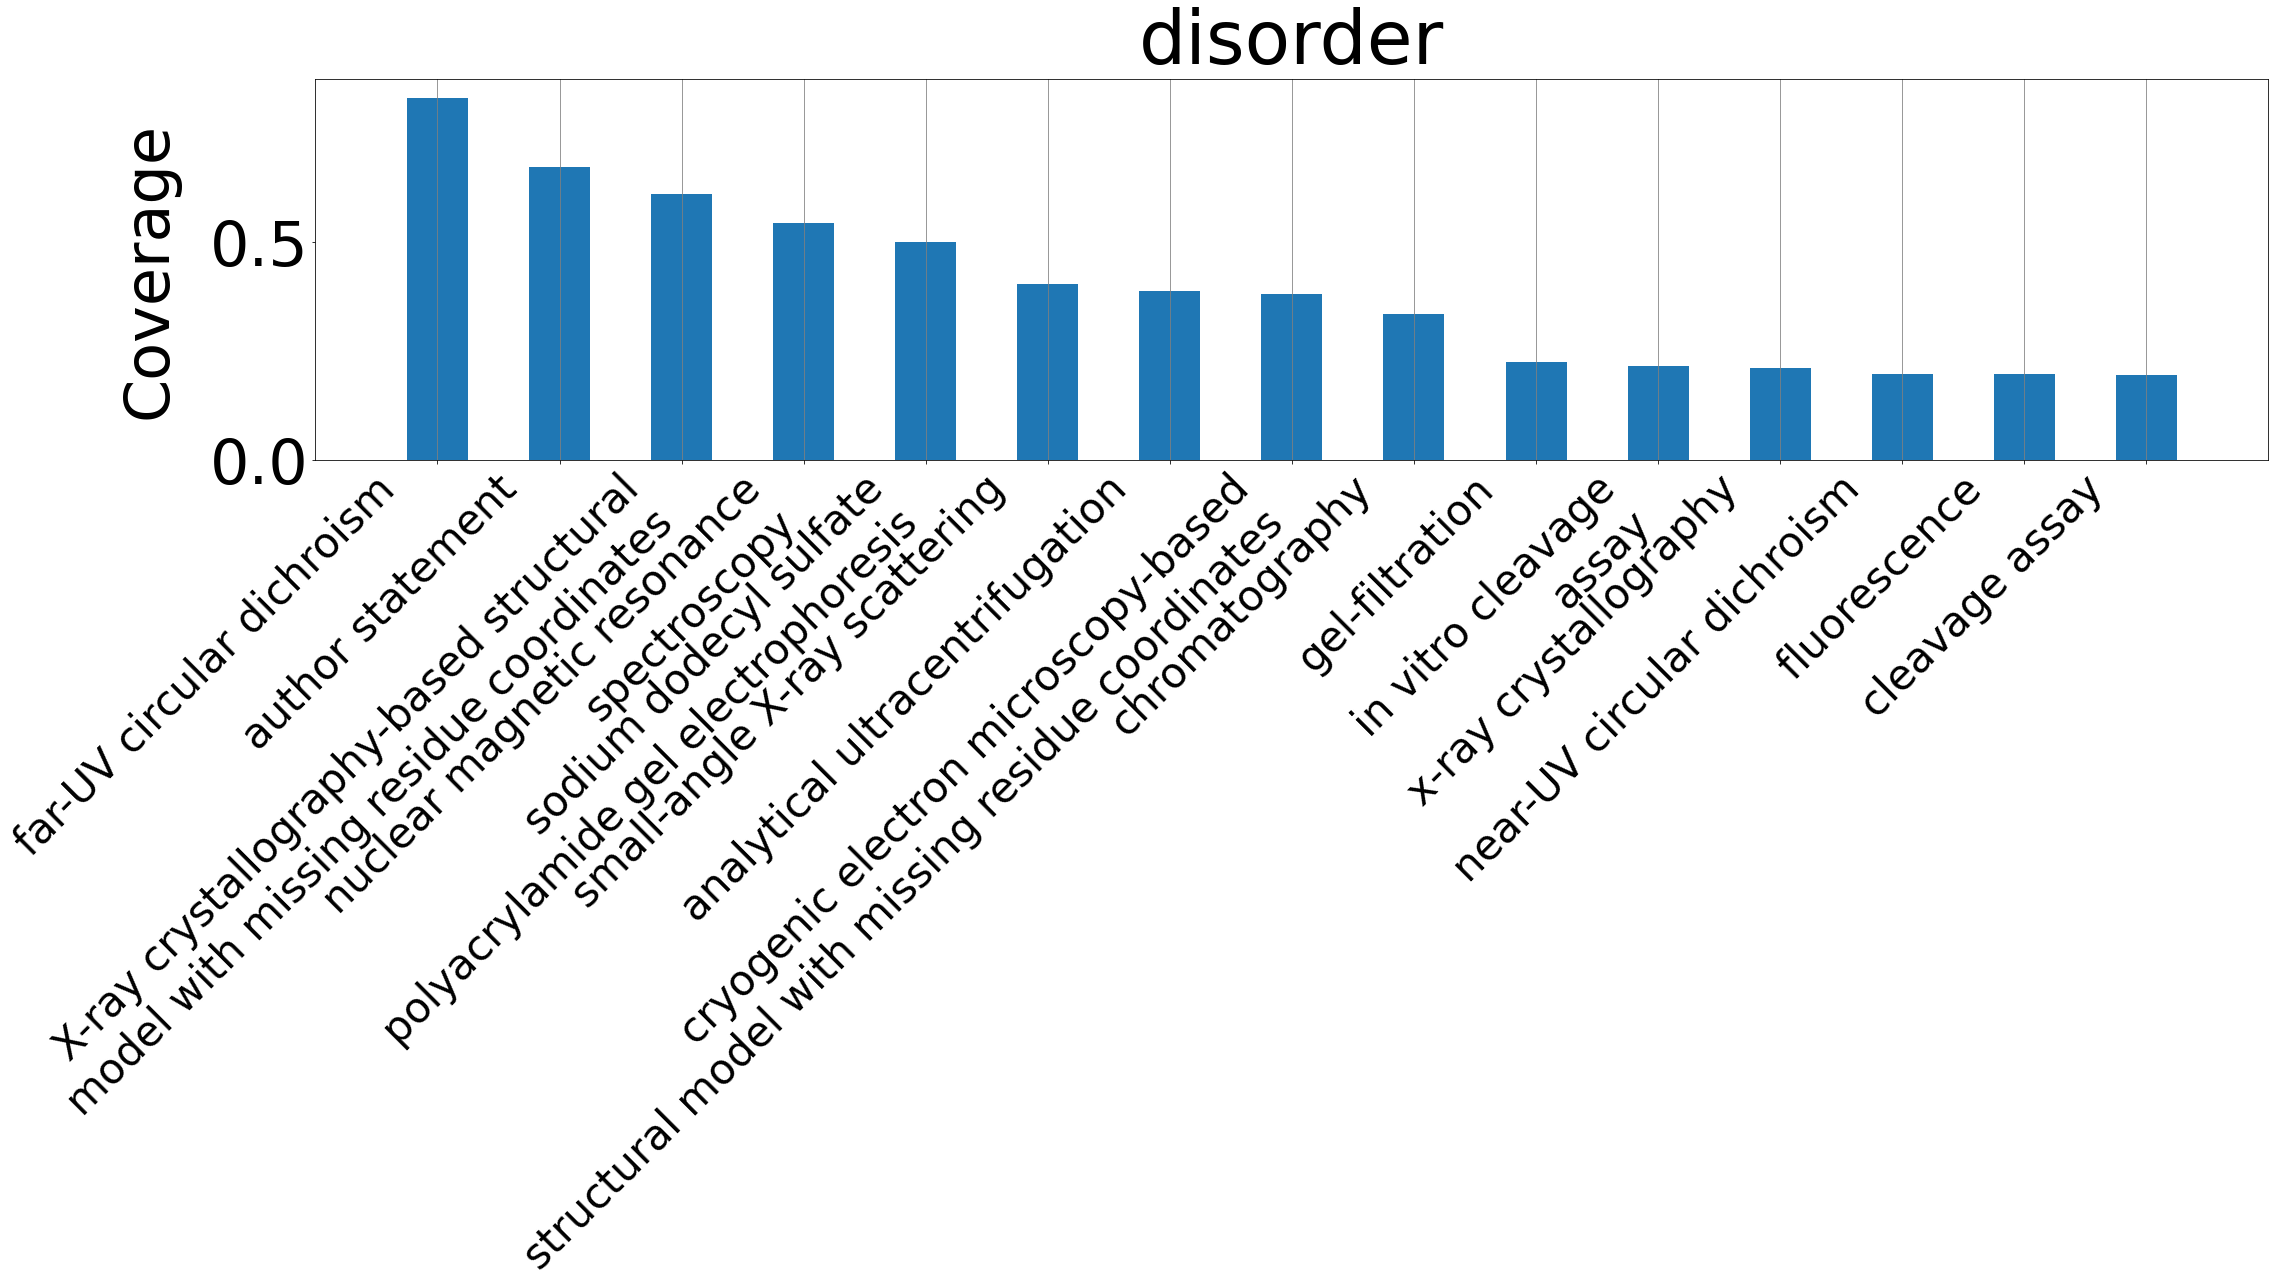

In [165]:
plt.rcParams.update({'font.size': 62, 'savefig.transparent': True, 'xtick.labelsize': 42})

for challenge, df_g in df_ec.groupby('challenge'):
    if challenge in ['disorder']:

        fig, ax = plt.subplots(figsize=(35, 7))
        df_g['ec_name'] = df_g['ec_name'].map(lambda x: x.split('evidence')[0].split('used')[0])
        df_g['ec_name'] = df_g['ec_name'].map(lambda x: " ".join(x.split()[:3]) + "\n" + " ".join(x.split()[3:]))
        df_g.set_index('ec_name').sort_values(by='fraction', ascending=False)['fraction'].iloc[:15].plot(kind='bar', ax=ax, align='center')
        ax.xaxis.grid()
        ax.set_ylabel('Coverage', labelpad=30)
        plt.xticks(rotation = 45, ha='right')

        plt.title(challenge)
        fig.gca().set_xlabel("")
        ax.set_xbound(-1, 15)

        fig.gca().set_xlabel("")
        fig.savefig("{}/stat_ec_{}_vertical.png".format(fig_dir, challenge), dpi=300, bbox_inches='tight')
        # break